# Learning Outcomes

## Image segmentation technique

1. k-means clustering
2. anistropic segmentation (produce gradient structure tensor, followed by thresholding)
3. watershed segmentation (marker-controlled)

## Setup

In [2]:
!pip install requests


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\HP\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [4]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## Simple demo of k-means clustering

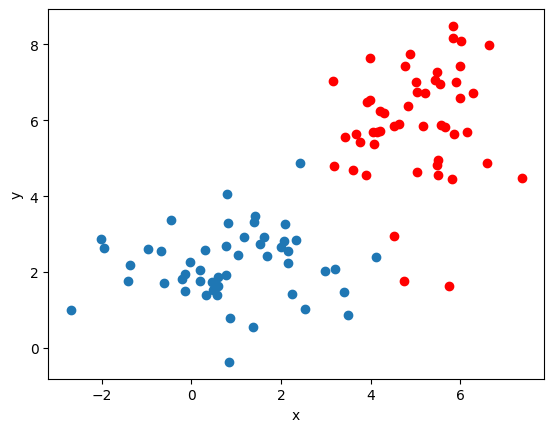

In [18]:
np.random.seed(99) # everytime generate same things

# create first batch of data
mean1 = (1, 2)
cov1 = np.array([[2, 0], [0, 1]])
dat1 = np.random.multivariate_normal(mean1, cov1, size = 50)

# create second batch of data
mean2 = (5, 6)
cov2 = np.array([[1, 0], [0, 2]])
dat2 = np.random.multivariate_normal(mean2, cov2, size = 50)

# concatenate
data = np.vstack((dat1, dat2))
Z = np.float32(data)

# visualize
plt.scatter(dat1[:, 0], dat1[:, 1])
plt.scatter(dat2[:, 0], dat2[:, 1], c="r")
plt.xlabel("x"), plt.ylabel("y")
plt.show()

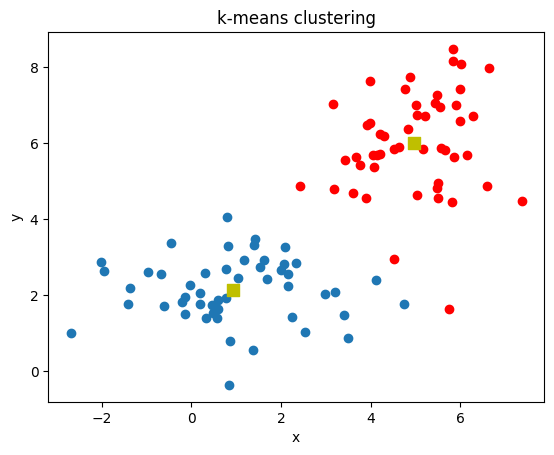

In [19]:
# k-means clustering
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv.kmeans(Z, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
# ret is WCSOS

# subset the data into clusters defined
A = Z[label.flatten() == 0]
B = Z[label.flatten() == 1]

plt.scatter(A[:, 0], A[:, 1])
plt.scatter(B[:, 0], B[:, 1], c="r")
plt.scatter(center[:, 0], center[:, 1], c="y", marker="s", s=80)
plt.xlabel("x"), plt.ylabel("y")
plt.title("k-means clustering")
plt.show()

In [20]:
# apply k-means clustering on image
def k_means_clust(img, K, max_iter=10, eps=1.0, attempts=10, flag=cv.KMEANS_PP_CENTERS):
    """Args:
    img: 3-channel color image
    K: user defined number of cluster
    by default, max_iter=10, eps=1, attempts=10, k-means++"""
    
    # reshape and cast
    img = img.reshape((-1, 3))
    img = np.float32(img)
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, max_iter, eps)
    
    return cv.kmeans(img, K, None, criteria, attempts, flag)

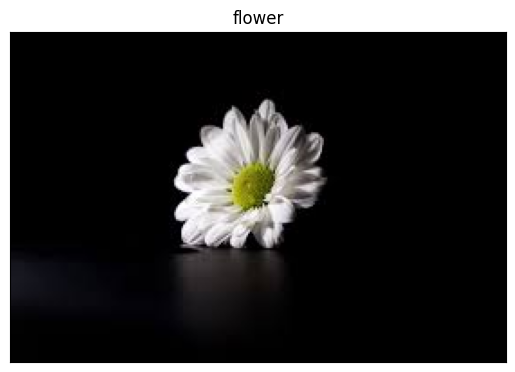

In [25]:
img = cv.imread("images/flower.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt_img(img_rgb, "flower")

In [26]:
# call the function
ret, label, center = k_means_clust(img_rgb, 3)

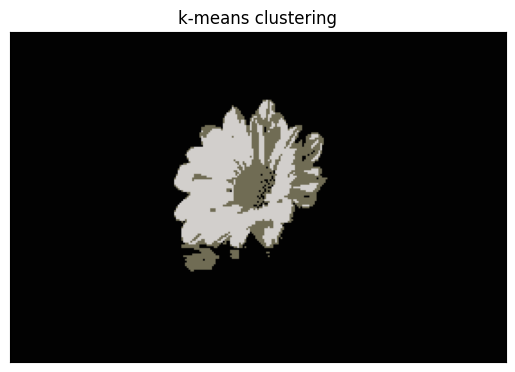

In [27]:
#
center = np.uint8(center)
res = center[label.ravel()]
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means clustering")

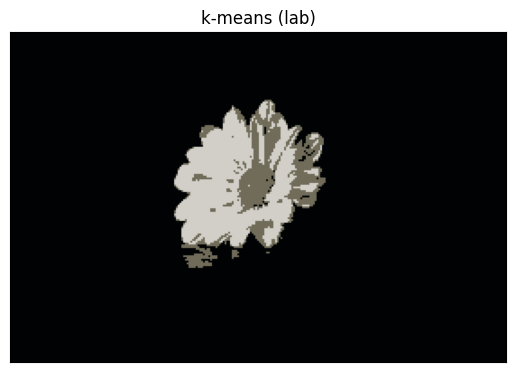

In [30]:
# LAB color space because of perceptual uniformity

img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
ret, label, center = k_means_clust(img_lab, 3)

center = np.uint8(center)
res = center[label.ravel()]
quant = res.reshape(img_lab.shape)

quant_rgb = cv.cvtColor(quant, cv.COLOR_Lab2RGB)

plt_img(quant_rgb, "k-means (lab)")

In [31]:
# interested to know the distribution of clusters
np.unique(res, axis=0, return_counts=True)

(array([[  1, 128, 127],
        [116, 126, 139],
        [212, 128, 131]], dtype=uint8),
 array([45470,  1786,  3069], dtype=int64))

In [32]:
# bar plot
centroids, counts = np.unique(res, axis=0, return_counts=True) # lab

# change centroid to rgb (diff from notes)
centroids = centroids.reshape((3, 1, 3))
centroids_rgb = cv.cvtColor(centroids, cv.COLOR_Lab2RGB)
centroids_rgb = centroids_rgb.reshape((3, 3))

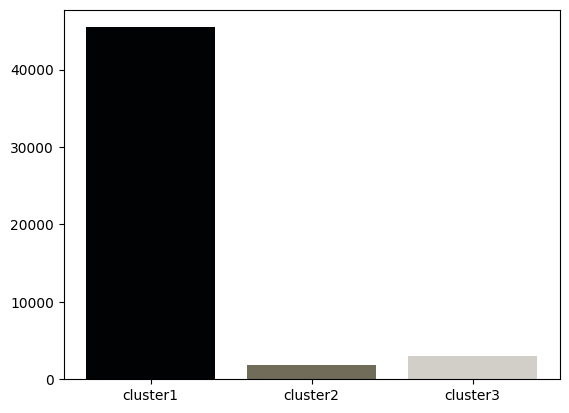

In [34]:
#
xlabel_name = ['cluster' + str(i) for i in range(1, 4)]

plt.bar(xlabel_name, counts, color=list(centroids_rgb / 255))

plt.show()

## Anisotropic segmentation

In [35]:
def calcGST(inputIMG, w, edge_method="scharr"):
    img = np.float32(inputIMG)
    
    # Gradient structure tensor components
    if edge_method=="scharr":
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)
    elif elif_method=="sobel":
        imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1)
    else:
        raise Exception("No edge detection method")
        
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w, w))
    
    # eigenvalue
    tmp1 = J11+J22
    tmp2 = J11-J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0*tmp3)
    
    lambda1 = 0.5*(tmp1+tmp4)
    lambda2 = 0.5*(tmp1 - tmp4)
    
    # coherency
    imgCoherencyOut = cv.divide(lambda1-lambda2, lambda1+lambda2)
    
    # orientation calculation
    imgOrientationOut = cv.phase(J22-J11, 2.0*J12, angleInDegrees = True)
    imgOrientationOut = 0.5*imgOrientationOut
    
    return imgCoherencyOut, imgOrientationOut

In [ ]:
# I have attempted gaussian filtering, you will run into a numerical stability problem.
# To remedy this problem, add a small constant on 'J22-J11' on line 35. 
# Line 17-19 is where you can implement Gaussian filtering

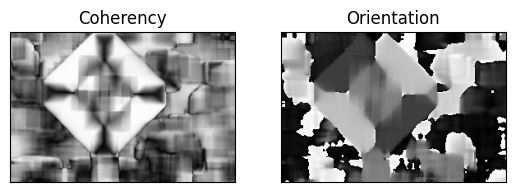

In [37]:
# visualize coherency and orientation
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (7, 7), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

W = 25
imgCoherency, imgOrientation = calcGST(gray, W) # coherency: 0-1, orientation: 0-180

imgCoherency_norm = cv.normalize(imgCoherency, None, alpha=0, beta=1, 
                                 norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
imgOrientation_norm = cv.normalize(imgOrientation, None, alpha=0, beta=1, 
                                 norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

plt.subplot(121), plt_img(imgCoherency_norm, "Coherency")
plt.subplot(122), plt_img(imgOrientation_norm, "Orientation")
plt.show()

In [44]:
# trackbar
def nothing(x):
    pass

wn = "anisoptropic segmentation"
cv.namedWindow(wn, cv.WINDOW_NORMAL | cv.WINDOW_FREERATIO)
cv.createTrackbar("Coherency threshold 1", wn, 50, 100, nothing)
cv.createTrackbar("Coherency threshold 2", wn, 70, 100, nothing)
cv.createTrackbar("Orientation threshold 1", wn, 50, 180, nothing) # 180 is important
cv.createTrackbar("Orientation threshold 2", wn, 100, 180, nothing)

# img = cv.imread("images/traffic_sign.jfif")
img = cv.imread("images/road.jpg")
blur = cv.GaussianBlur(img, (7, 7), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

W = 25
imgCoherency, imgOrientation = calcGST(gray, W)

while True:
    th_C_1 = cv.getTrackbarPos("Coherency threshold 1", wn) * 0.01
    th_C_2 = cv.getTrackbarPos("Coherency threshold 2", wn) * 0.01
    th_Or_1 = cv.getTrackbarPos("Orientation threshold 1", wn)
    th_Or_2 = cv.getTrackbarPos("Orientation threshold 2", wn)
    
    # perform thresholding
    imgBin_C_1 = cv.threshold(imgCoherency, th_C_1, 255, cv.THRESH_BINARY)[1]
    imgBin_C_2 = cv.threshold(imgCoherency, th_C_2, 255, cv.THRESH_BINARY_INV)[1]
    imgBin_Or_1 = cv.threshold(imgOrientation, th_Or_1, 255, cv.THRESH_BINARY)[1]
    imgBin_Or_2 = cv.threshold(imgOrientation, th_Or_2, 255, cv.THRESH_BINARY_INV)[1]
    
    imgBin_C = cv.bitwise_and(imgBin_C_1, imgBin_C_2)
    imgBin_Or = cv.bitwise_and(imgBin_Or_1, imgBin_Or_2)
    
    imgBin = cv.bitwise_and(imgBin_C, imgBin_Or)
    
    # mask, elementwise
    mask = imgBin != 0
    res = img*(mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    cv.imshow("segmentation mask", imgBin)
    
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()

## Watershed segmentation
Topopgrahic surface: edgme map <br>
marker: morphological gradient + thresholding

In [46]:
!pip install scikit-image

                                              0.0/22.8 MB ? eta -:--:--
                                              0.0/22.8 MB ? eta -:--:--
                                              0.0/22.8 MB ? eta -:--:--
                                             0.1/22.8 MB 491.5 kB/s eta 0:00:47
                                              0.2/22.8 MB 1.1 MB/s eta 0:00:22
                                              0.3/22.8 MB 1.3 MB/s eta 0:00:18
                                              0.3/22.8 MB 1.3 MB/s eta 0:00:18
                                              0.3/22.8 MB 1.3 MB/s eta 0:00:18
                                              0.4/22.8 MB 1.1 MB/s eta 0:00:21
                                              0.5/22.8 MB 1.1 MB/s eta 0:00:21
                                              0.5/22.8 MB 1.1 MB/s eta 0:00:21
                                              0.5/22.8 MB 1.1 MB/s eta 0:00:21
     -                                        0.6/22.8 MB 1.1 MB/s eta 0


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\HP\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [47]:
from skimage.segmentation import watershed # watershed
from scipy import ndimage as ndi # connected component labeling

In [98]:
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5, 5), 0)
# mean shift segmentation
blur = cv.pyrMeanShiftFiltering(blur, 15, 20, maxLevel=2)

show_img("mean shift", blur)

In [99]:
# change grayscale
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

# morphological gradient (structuring element)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
loc_grad = cv.morphologyEx(gray, cv.MORPH_GRADIENT, kernel, iterations = 2)

show_img("gradient", loc_grad)

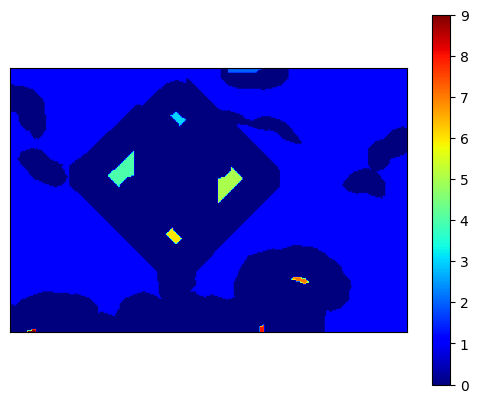

In [100]:
# thresholding
th = loc_grad < 80 # binary image

# connectivity
s = np.ones((3, 3), dtype=int)
marker = ndi.label(th, structure=s)[0]

plt.imshow(marker, cmap=plt.cm.jet)
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

In [101]:
# topographic graphic
edge = cv.Canny(gray, 250, 500)
labels = watershed(edge, marker)

In [102]:
np.unique(labels, return_counts=True) # 40736 are background

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

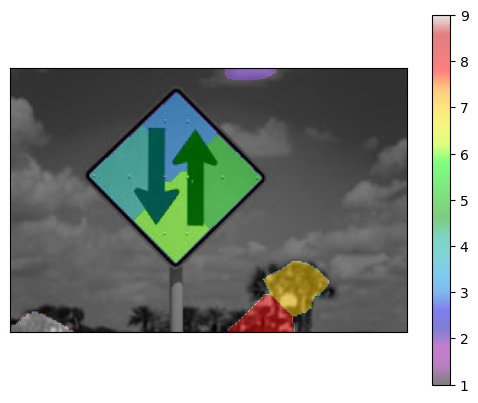

In [103]:
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap="gray")
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

In [104]:
# create white mask, suppress the pixel of background to 0, find contour
mask = 255* np.ones(labels.shape, dtype=np.uint8)

# assumption: background has the largest area
label_vec, counts = np.unique(labels, return_counts=True)
label_bg = label_vec[np.argmax(counts)]

mask[labels == label_bg] = 0

# find contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# grab the largest area contour
contour = sorted(contours, key=cv.contourArea, reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255, 0), 2)

show_img("contour", img_copy)

In [106]:
x, y, w, h = cv.boundingRect(contour)
img = cv.imread("images/traffic_sign.jfif")
cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
show_img("bounding box", img)

## watershed example
Topographic surface: -distance transform
<br>
Marker: thresholding + distance transform

In [108]:
# another traffic sifn image
img = cv.imread("images/traffic_sign1.jpg")

show_img("img", img)

In [109]:
# blurring
blur = cv.GaussianBlur(img, (5, 5), 0)

# convert to Lab
img_lab = cv.cvtColor(blur, cv.COLOR_BGR2LAB)

# k-means clustering
ret, label, center = k_means_clust(img_lab, 10)

# reshape
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_lab.shape)

quant_bgr = cv.cvtColor(quant, cv.COLOR_Lab2BGR)

show_img("k-means lan", quant_bgr)

In [110]:
# grayscale
gray = cv.cvtColor(quant_bgr, cv.COLOR_BGR2GRAY)

# otsu thresholding
th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

# morphological opening
kernel = np.ones((3, 3), dtype=np.uint8)
th = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=3)

show_img("th", th)

In [111]:
from skimage.feature import peak_local_max

In [112]:
# distance transform
dist_transform = cv.distanceTransform(th, cv.DIST_L2, 3)

# mask
mask = np.zeros(dist_transform.shape, dtype=bool)
coords = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=th)
mask[tuple(coords.T)] = True
marker = ndi.label(mask)[0]

# watershed
labels = watershed(-dist_transform, marker, mask=th)

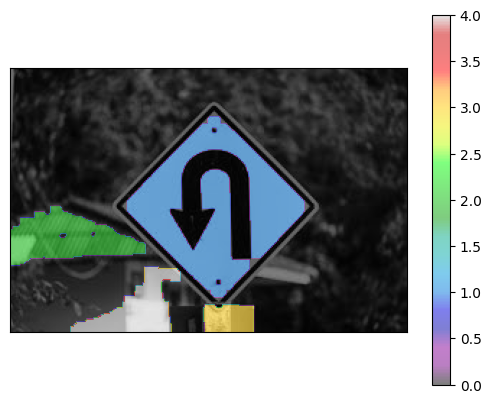

In [113]:
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap="gray")
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

In [114]:
# create white mask, suppress the pixel of background to 0, find contour
mask = 255* np.ones(labels.shape, dtype=np.uint8)

# assumption: background has the largest area
label_vec, counts = np.unique(labels, return_counts=True)
label_bg = label_vec[np.argmax(counts)]

mask[labels == label_bg] = 0

# find contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# grab the largest area contour
contour = sorted(contours, key=cv.contourArea, reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255, 0), 2)

show_img("contour", img_copy)

## exercise 1


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\

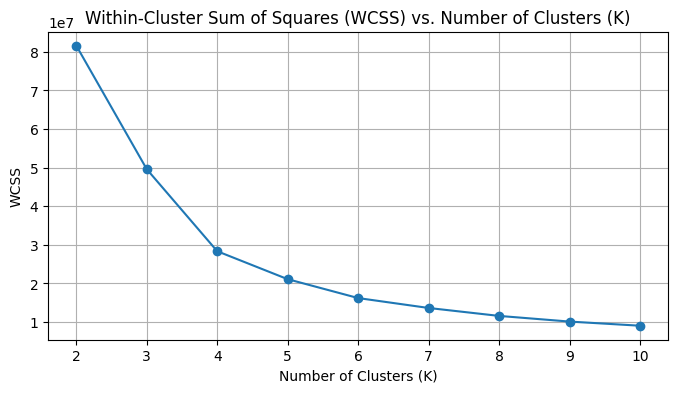

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


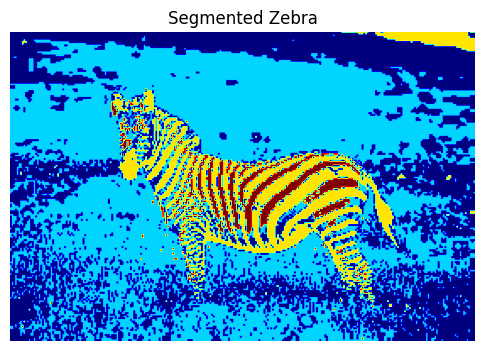

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the image
image = cv2.imread(r'C:\Users\User\Documents\Y3S1\MINI PROJECT\WEEK 9\zebra.jfif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image into a 2D array of pixels
pixels = image.reshape(-1, 3)

# Determine the optimal K by plotting the WCSS for K values ranging from 2 to 10
wcss = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(pixels)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values to determine the optimal K
plt.figure(figsize=(8, 4))
plt.plot(k_range, wcss, marker='o', linestyle='-')
plt.title('Within-Cluster Sum of Squares (WCSS) vs. Number of Clusters (K)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Choose the optimal K based on the elbow point from the plot (manually in this case)
optimal_k = 4

# Apply K-means clustering with the chosen K
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(pixels)
clustered_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Reshape the clustered labels back to the original image shape
clustered_image = clustered_labels.reshape(image.shape[:2])

# Display the segmented image
plt.figure(figsize=(6, 6))
plt.imshow(clustered_image, cmap='jet')
plt.title('Segmented Zebra')
plt.axis('off')
plt.show()
